In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader import PuljaDataLoader
from models._20220707_00 import UserModel
from models.utils import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 1000

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c1, dataset.num_c2, dataset.num_c4, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
tb_unit1 = pd.read_csv(
    os.path.join("tables", "tb_unit1.csv")
)
tb_unit2 = pd.read_csv(
    os.path.join("tables", "tb_unit2.csv")
)

c22c1 = {}
for _, row in tb_unit2.iterrows():
    c2 = row["name"]
    c1 = tb_unit1[tb_unit1["unit1Seq"] == row["unit1Seq"]]["name"].values[0]
    
    c22c1[c2] = c1

c22c1_indices = [dataset.c12idx[c22c1[c2]] for c2 in [dataset.c2_list[i] for i in range(dataset.num_c2)]]

In [4]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_20220707_00"
            ),
            "model_fin.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (D): Embedding(7, 1)
  (R): Embedding(2, 20)
  (gru): GRU(40, 20, batch_first=True)
  (linear_1): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=100, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=3, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
)

In [5]:
aucs_list = []
max_aucs = []
fin_aucs = []

dir_list = ["01"]

for i in dir_list:
    with open(
        os.path.join(
            os.path.join(
                ckpt_path,
                os.path.join("_20220707_00", i)
            ),
            "aucs.pkl"
        ),
        "rb"
    ) as f:
        aucs = pickle.load(f)
    
    max_auc = np.max(aucs)
    fin_auc = aucs[-1]

    aucs_list.append(aucs)
    max_aucs.append(max_auc)
    fin_aucs.append(fin_auc)

In [6]:
print("max_aucs: {}".format(max_aucs))
print("max_auc_mean: {}, max_auc_std: {}".format(np.mean(max_aucs), np.std(max_aucs)))
print("max_auc_dir: {}".format(dir_list[np.argmax(max_aucs)]))

max_aucs: [0.7751930286492286]
max_auc_mean: 0.7751930286492286, max_auc_std: 0.0
max_auc_dir: 01


In [7]:
print("max_fin_aucs: {}".format(fin_aucs))
print("max_fin_auc_mean: {}, max_auc_std: {}".format(np.mean(fin_aucs), np.std(fin_aucs)))
print("max_fin_auc_dir: {}".format(dir_list[np.argmax(fin_aucs)]))

max_fin_aucs: [0.7748271059751857]
max_fin_auc_mean: 0.7748271059751857, max_auc_std: 0.0
max_fin_auc_dir: 01


In [8]:
test_dataset[6]

(array([7, 7, 7, ..., 6, 6, 6]),
 array([141, 141, 141, ..., 137, 137, 137]),
 array([517, 517, 517, ..., 363, 363, 363]),
 array([0, 2, 2, ..., 0, 0, 1]),
 array([1., 0., 0., ..., 1., 0., 0.]))

In [9]:
# 0, 6
c1_seq, c2_seq, c4_seq, d_seq, r_seq = test_dataset[6]

view_from = 0
view_to = 200

seq_len = view_to - view_from

c1_seq = [c1_seq[view_from:view_to]]
c2_seq = [c2_seq[view_from:view_to]]
c4_seq = [c4_seq[view_from:view_to]]
d_seq = [d_seq[view_from:view_to]]
r_seq = [r_seq[view_from:view_to]]

# r_seq = np.zeros_like(r_seq)
# r_seq = np.ones_like(r_seq)

# d_seq = np.ones_like(d_seq) * 6

# c_seq = np.array([[0] * 100])
# d_seq = np.array([[6] * 30 + [3] * 30 + [0] * 40])
# r_seq = np.ones_like(r_seq)

# c1_seq, c2_seq, c4_seq, d_seq, r_seq: [batch_size, seq_len]

alpha_seq, h_seq, C1_seq, C2_seq, C4_seq = model(
    LongTensor(c1_seq),
    LongTensor(c2_seq),
    LongTensor(c4_seq),
    LongTensor(d_seq),
    LongTensor(r_seq),
)

# C1_seq: [batch_size, seq_len ,num_c1]
# C2_seq: [batch_size, seq_len, num_c2]
# C4_seq: [batch_size, seq_len, num_c4]

# beta1_seq: [batch_size, seq_len]
# beta2_seq: [batch_size, seq_len]
# beta4_seq: [batch_size, seq_len]
beta1_seq = torch.gather(C1_seq, dim=-1, index=LongTensor(c1_seq).unsqueeze(-1)).reshape([1, seq_len])
beta2_seq = torch.gather(C2_seq, dim=-1, index=LongTensor(c2_seq).unsqueeze(-1)).reshape([1, seq_len])
beta4_seq = torch.gather(C4_seq, dim=-1, index=LongTensor(c4_seq).unsqueeze(-1)).reshape([1, seq_len])

# gamma_seq: [seq_len]
gamma_seq = model.D(LongTensor(d_seq)).squeeze()

###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

sigmoid_alpha_beta2_seq = torch.sigmoid(alpha_seq + beta1_seq + beta2_seq).detach().cpu().numpy()[0]
sigmoid_alpha_beta4_seq = torch.sigmoid(alpha_seq + beta1_seq + beta2_seq + beta4_seq).detach().cpu().numpy()[0]

sigmoid_alpha_beta_gamma_seq = torch.sigmoid(alpha_seq + beta1_seq + beta2_seq - gamma_seq).detach().cpu().numpy()[0]

sigmoid_beta4_seq = torch.sigmoid(beta4_seq).detach().cpu().numpy()[0]

r_seq_ma = np.cumsum(r_seq[0]) / np.arange(1, r_seq[0].shape[0] + 1)

CQ_seq = alpha_seq.unsqueeze(-1) + C1_seq.squeeze()[:, c22c1_indices] + C2_seq.squeeze()
CQ_seq = torch.sigmoid(CQ_seq).detach().cpu().numpy()[0]

CQ4_seq = alpha_seq.unsqueeze(-1) + C4_seq.squeeze()
CQ4_seq = torch.sigmoid(CQ4_seq).detach().cpu().numpy()[0]

C1_seq = C1_seq.squeeze().detach().cpu().numpy()
C2_seq = C2_seq.squeeze().detach().cpu().numpy()
C4_seq = C4_seq.squeeze().detach().cpu().numpy()

# alpha_seq = alpha_seq.detach().cpu().numpy()

<ipython-input-9-11d746e88b28>:31: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  LongTensor(r_seq),


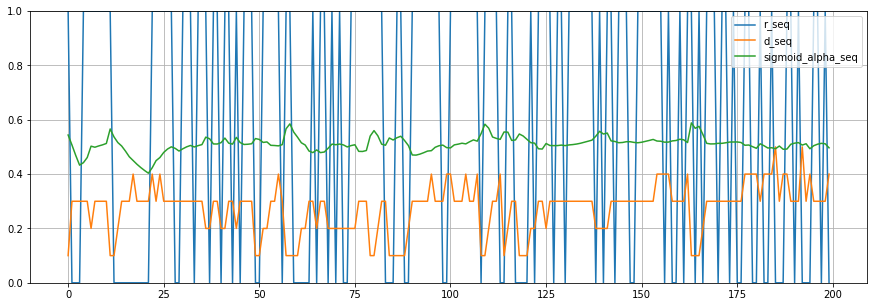

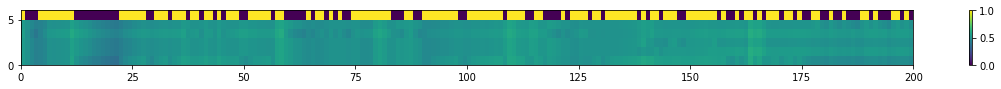

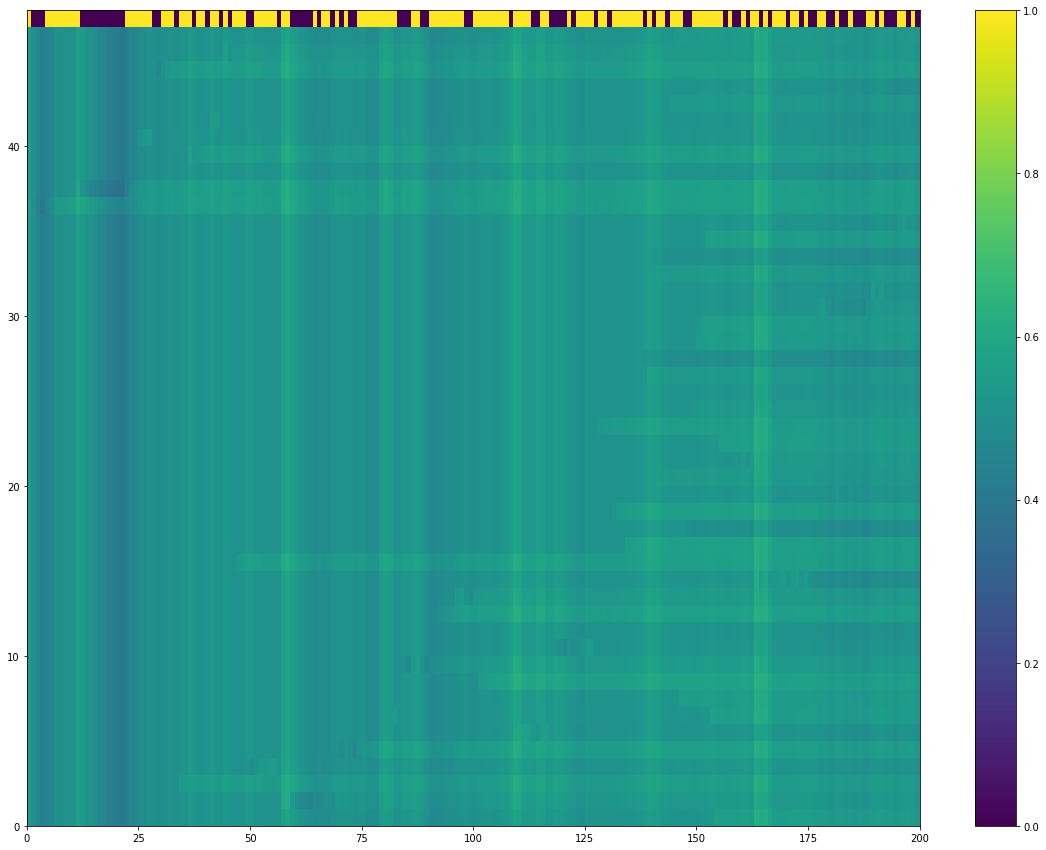

In [10]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
# plt.plot(sigmoid_alpha_beta2_seq, label="sigmoid_alpha_beta2_seq")
# plt.plot(sigmoid_alpha_beta4_seq, label="sigmoid_alpha_beta4_seq")
# plt.plot(sigmoid_beta4_seq, label="sigmoid_beta4_seq")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.figure(figsize=[20, len(np.unique(c2_seq)) // 3], facecolor="white")
temp = np.concatenate([CQ_seq[:, np.unique(c2_seq)].T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

plt.figure(figsize=[20, len(np.unique(c4_seq)) // 3], facecolor="white")
temp = np.concatenate([CQ4_seq[:, np.unique(c4_seq)].T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

In [11]:
CQ4_seq[0][np.unique(c4_seq)]

array([0.54373956, 0.54373956, 0.54373956, 0.54373956, 0.54373956,
       0.54373956, 0.54373956, 0.54373956, 0.54373956, 0.54373956,
       0.54373956, 0.54373956, 0.54373956, 0.54373956, 0.54373956,
       0.54373956, 0.54373956, 0.54373956, 0.54373956, 0.54373956,
       0.54373956, 0.54373956, 0.54373956, 0.54373956, 0.54373956,
       0.54373956, 0.54373956, 0.54373956, 0.54373956, 0.54373956,
       0.54373956, 0.54373956, 0.54373956, 0.54373956, 0.54373956,
       0.54373956, 0.56492954, 0.54373956, 0.54373956, 0.54373956,
       0.54373956, 0.54373956, 0.54373956, 0.54373956, 0.54373956,
       0.54373956, 0.54373956], dtype=float32)

In [12]:
CQ4_seq[-1][np.unique(c4_seq)]

array([0.53498864, 0.5149001 , 0.5322419 , 0.5007081 , 0.5366699 ,
       0.4939189 , 0.5329908 , 0.5294018 , 0.547743  , 0.52390295,
       0.49893975, 0.48985636, 0.54541206, 0.5219457 , 0.47254875,
       0.53774637, 0.5422585 , 0.47231036, 0.53790593, 0.50064784,
       0.51563907, 0.52013975, 0.5346269 , 0.5326792 , 0.5133572 ,
       0.49829483, 0.5149039 , 0.47020978, 0.5271568 , 0.5311692 ,
       0.51419765, 0.5005364 , 0.52018106, 0.47620153, 0.5324371 ,
       0.49817777, 0.5425911 , 0.5394396 , 0.4857411 , 0.5322757 ,
       0.49981636, 0.49590993, 0.5178905 , 0.4732185 , 0.5363858 ,
       0.5183858 , 0.5215506 ], dtype=float32)

In [13]:
CQ_seq[0][np.unique(c2_seq)], CQ_seq[-1][np.unique(c2_seq)]

(array([0.54373956, 0.54373956, 0.54373956, 0.5587509 , 0.54373956],
       dtype=float32),
 array([0.46961507, 0.5273135 , 0.49429306, 0.52981824, 0.4941774 ],
       dtype=float32))

In [14]:
np.unique(c2_seq), c2_seq

(array([138, 139, 140, 141, 169]),
 [array([141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 138, 138,
         138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138,
         138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 141, 141, 141,
         141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 138, 138, 138,
         138, 138, 138, 138, 138, 141, 141, 141, 141, 141, 141, 141, 141,
         141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141,
         141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141,
         141, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138,
         138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138,
         138, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 138, 138,
         138, 138, 138, 138, 138, 138, 138, 138, 139, 140, 140, 141, 139,
         139, 139, 140, 140, 140, 140, 140, 141, 141, 141, 141, 139, 140,
         140, 141, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138,
   

In [15]:
np.unique(c4_seq), c4_seq

(array([  7,  20,  36,  43,  54,  75,  80,  81, 125, 129, 139, 141, 144,
        159, 185, 198, 203, 225, 236, 251, 263, 291, 293, 302, 304, 318,
        366, 384, 389, 426, 439, 450, 464, 465, 481, 505, 517, 529, 532,
        534, 570, 573, 574, 590, 607, 611, 621]),
 [array([517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 529, 529,
         529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 570,
         570, 570, 570, 607, 607, 607, 607,  36,  36,  36, 534, 534, 534,
         534, 573, 573, 573, 573, 611, 611, 611, 198, 198,  43,  43,  43,
          43,  43,  43,  43,  43,  20,  20,  20,  20,  20,  20,  20,  20,
          20,  20,  20,  20,  20,  54,  54,  54,  54,  54,  54,  54,  54,
          54,  54,  54,  54,  80,  80, 129, 129, 129, 129, 129, 129, 129,
         129, 144, 144, 144, 144, 159, 159, 159, 159, 159, 125, 125, 125,
         125, 125, 125, 125,  75,  75,  75,  75,  75,  75,  75,  75,  75,
          75, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 3

In [16]:
d_seq

[array([0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 3, 2, 2, 2, 2,
        3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2,
        1, 2, 2, 2, 2, 0, 0, 1, 1, 2, 2, 3, 2, 0, 0, 0, 0, 1, 1, 2, 2, 1,
        2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0,
        0, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 3, 0, 0,
        1, 2, 2, 3, 0, 1, 2, 2, 0, 0, 0, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 2, 2, 2, 2, 3, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 3, 3, 3, 3, 2, 3, 3, 3, 4, 2, 3, 3, 2, 2, 2, 4, 2, 3, 2, 2, 2,
        2, 3])]

In [17]:
c1_seq, c2_seq

([array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6,
         6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6, 6])],
 [array([141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 138, 138,
         138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138,
         138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 141, 141, 141,
         141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 138, 138, 138,
         13

In [18]:
model.D.weight

Parameter containing:
tensor([[-0.7532],
        [-0.5087],
        [-0.1859],
        [ 0.3139],
        [ 0.6964],
        [ 0.9359],
        [ 0.4867]], requires_grad=True)

In [19]:
h_seq.shape

torch.Size([1, 200, 20])

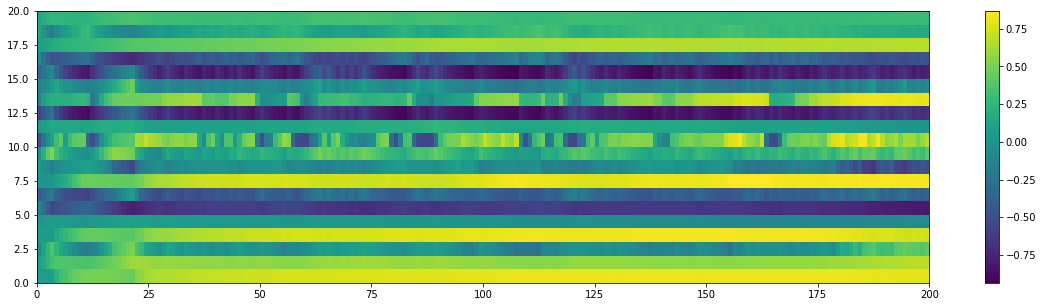

In [20]:
plt.figure(figsize=[20, 5], facecolor="white")
plt.pcolormesh(h_seq[0].detach().cpu().numpy().T)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()